[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015). 

<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>This tutorial: An encoder/decoder connected by attention.</th>
<tr>
</table>

While this architecture is somewhat outdated, it is still a very useful project to work through to get a deeper understanding of sequence-to-sequence models and attention mechanisms (before going on to [Transformers](transformer.ipynb)).

## Setup

In [ ]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.1 MB/s 
     |████████████████████████████████| 588.3 MB 6.7 kB/s 
     |████████████████████████████████| 439 kB 69.9 MB/s 
     |████████████████████████████████| 1.7 MB 57.3 MB/s 
     |████████████████████████████████| 6.0 MB 56.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ai_model/improve

/content/drive/MyDrive/ai_model/improve


In [ ]:
with open("ba2ba/train_vi.txt", 'r', encoding='utf8') as f:
  train_raw_vi = np.array(f.read().split('\n'))

with open("ba2ba/train_predictedba.txt", 'r', encoding='utf8') as f:
  train_raw_predictedba = np.array(f.read().split('\n'))

with open("ba2ba/train_ba.txt", 'r', encoding='utf8') as f:
  train_raw_ba = np.array(f.read().split('\n'))


In [ ]:
BUFFER_SIZE = len(train_raw_vi)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(train_raw_vi),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_raw_vi[is_train], train_raw_predictedba[is_train], train_raw_ba[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_raw_vi[~is_train], train_raw_predictedba[~is_train], train_raw_ba[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, pred, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(pred[:5])
  print(0)
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'ma qu\xe1\xbb\xb7'
 b'Ban Tham v\xe1\xba\xa5n H\xe1\xbb\x99i \xc4\x91\xe1\xbb\x93ng tr\xe1\xba\xbb em g\xe1\xbb\x93m \xc4\x91\xe1\xba\xa1i di\xe1\xbb\x87n c\xc3\xa1c s\xe1\xbb\x9f, ban, ng\xc3\xa0nh, \xc4\x91o\xc3\xa0n th\xe1\xbb\x83 li\xc3\xaan quan c\xe1\xbb\xa7a t\xe1\xbb\x89nh v\xc3\xa0 c\xc3\xa1c c\xc3\xa1 nh\xc3\xa2n, t\xe1\xbb\x95 ch\xe1\xbb\xa9c x\xc3\xa3 h\xe1\xbb\x99i li\xc3\xaan quan \xc4\x91\xe1\xba\xbfn l\xc4\xa9nh v\xe1\xbb\xb1c tr\xe1\xba\xbb em.'
 b'chi\xe1\xba\xbfu'
 b'T\xe1\xbb\xab ngu\xe1\xbb\x93n v\xe1\xbb\x91n n\xc3\xa0y, nhi\xe1\xbb\x81u h\xe1\xbb\x99i vi\xc3\xaan ph\xe1\xbb\xa5 n\xe1\xbb\xaf \xc4\x91\xc3\xa3 s\xe1\xbb\xad d\xe1\xbb\xa5ng \xc4\x91\xc3\xbang m\xe1\xbb\xa5c \xc4\x91\xc3\xadch v\xc3\xa0 ph\xc3\xa1t huy hi\xe1\xbb\x87u qu\xe1\xba\xa3'
 b'g\xe1\xba\xadp'], shape=(5,), dtype=string)

tf.Tensor(
[b'l\xc3\xaah l\xc3\xaam .'
 b"khul tham v\xe1\xba\xa5n h\xc3\xb4i \xc4\x91\xc3\xb4ng \xc4\x91e h\xc6\xa1 'y\xc4\x95 thoi \xc4\x91ai rim s\xc6\xa1 

### Text preprocessing

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

Unicode normalization will be the first step in the text standardization function:

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text)
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.

  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

#### Text Vectorization

In [ ]:
max_vocab_size = 6000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda train_vi, train_predictedba,train_ba: train_vi))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', ',', '.', 'các', 'và', 'của', 'dân']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda train_vi, train_predictedba,train_ba: train_ba))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', ',', 'tơdrong', 'rim', 'pơm', 'weng', '.']

In [ ]:
predicted_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
predicted_text_processor.adapt(train_raw.map(lambda train_vi, train_predictedba,train_ba: train_predictedba))
predicted_text_processor.get_vocabulary()[:10]


['', '[UNK]', '.', '[START]', '[END]', ',', 'tơdrong', 'rim', 'pơm', 'weng']

Now these layers can convert a batch of strings into a batch of token IDs:

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 911, 1429, 3],
 [2, 62, 124, 401, 11, 25, 215, 165, 745, 255, 304, 6, 43, 4, 62, 4, 149, 4,
  146, 117, 147, 60, 8, 32, 7, 6, 230, 57, 4, 36, 31, 16, 11, 147, 60, 77,
  506, 345, 215, 165, 5, 3]                                                 ,
 [2, 1062, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ma quỷ [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

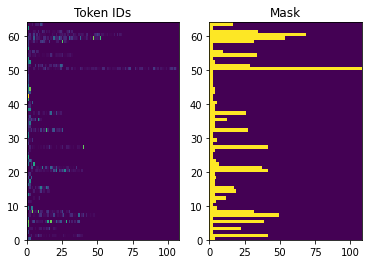

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [ ]:
def process_text(context, predicted,target):
  context = context_text_processor(context).to_tensor()
  predicted = predicted_text_processor(predicted).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, predicted, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [ ]:
for (ex_context_tok,predicted, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(predicted)
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2 178  20   4 201  11 460  36  31  21]

tf.Tensor(
[[   3    7   30 ...    0    0    0]
 [   3  106  244 ...    0    0    0]
 [   3  518  112 ...    0    0    0]
 ...
 [   3  958  842 ...    0    0    0]
 [   3  132 2281 ...    0    0    0]
 [   3    6    8 ...    0    0    0]], shape=(64, 84), dtype=int64)

[  2   6  16   4 112  22 620  28  13 167]
[  6  16   4 112  22 620  28  13 167 183]


## The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word. 

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [ ]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {predicted.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_tar_in.shape}')

Context tokens, shape (batch, s): (64, 83)
Encoder output, shape (batch, s, units): (64, 84)
Encoder output, shape (batch, s, units): (64, 76)


In [ ]:
target_text_processor.vocabulary_size()

6000

In [ ]:
ex_context_tok

<tf.Tensor: shape=(64, 83), dtype=int64, numpy=
array([[   2,  178,   20, ...,    0,    0,    0],
       [   2,   57,  636, ...,    0,    0,    0],
       [   2, 2317,  217, ...,    0,    0,    0],
       ...,
       [   2,  726, 1195, ...,    0,    0,    0],
       [   2, 1932,  172, ...,    0,    0,    0],
       [   2,  133,   83, ...,    0,    0,    0]])>

### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 83, 256)
Target sequence, shape (batch, t, units): (64, 76, 256)
Attention result, shape (batch, t, units): (64, 76, 256)
Attention weights, shape (batch, t, s):    (64, 76, 83)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       1.        , 1.        , 0.99999994, 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 1.        , 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999



Here are the attention weights across the context sequences at `t=0`:

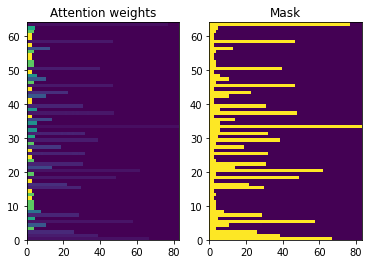

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token. 

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 83, 256)
input target tokens shape: (batch, t) (64, 76)
logits shape shape: (batch, target_vocabulary_size) (64, 76, 6000)


#### Inference

To use it for inference you'll need a couple more methods:

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'br\xc6\xb0a (tr\xc5\x8f \xc6\xa1\xc5\x8fi viii ahr\xc4\x95i" 95% p\xc6\xa1g\xc5\x8fp canh; r\xc3\xa0 \xc4\x90\xc4\x83t',
       b"j\xc6\xb0v\xc4\x95i 'y\xc5\x8fk: r\xc4\x83p 'bich giam dtts thuy p\xc6\xa1l\xc6\xa1k lich ti\xc3\xaa\xcc\x86p",
       b'2021 bok; nh\xc6\xa1 k\xc6\xa1n\xc4\xadt li\xc3\xaam 376 p\xc3\xaang/tt-bgd\xc4\x90t tr\xc4\xadnh b\xc6\xa1j\xc4\x83ng g\xc3\xaar)'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               predicted_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    # encoder = Encoder(context_text_processor, units)
    encoder2 = Encoder(predicted_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.encoder2= encoder2
    self.decoder = decoder

  def call(self, inputs):
    context, predicted, x = inputs
    context = self.encoder(context)
    predicted = self.encoder2(predicted)
    
    logits = self.decoder(predicted, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, predicted_text_processor, target_text_processor)

logits = model((ex_context_tok, predicted, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 83)
Target tokens, shape: (batch, t) (64, 76)
logits, shape: (batch, t, target_vocabulary_size) (64, 76, 6000)


During training the model will be used like this:

### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.625509, 'expected_acc': 0.00017946877243359656}

That should roughly match the values returned by running a few steps of evaluation:

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 11s 44ms/step - loss: 8.6995 - masked_acc: 3.9068e-04 - masked_loss: 8.6995


{'loss': 8.69951057434082,
 'masked_acc': 0.00039068417390808463,
 'masked_loss': 8.69951057434082}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


100/100 [==============================] - 60s 399ms/step - loss: 6.3613 - masked_acc: 0.0900 - masked_loss: 6.3613 - val_loss: 5.7037 - val_masked_acc: 0.1357 - val_masked_loss: 5.7037
Epoch 2/100
100/100 [==============================] - 24s 235ms/step - loss: 4.8551 - masked_acc: 0.2395 - masked_loss: 4.8523 - val_loss: 4.2783 - val_masked_acc: 0.2837 - val_masked_loss: 4.2783
Epoch 3/100
100/100 [==============================] - 24s 243ms/step - loss: 3.9637 - masked_acc: 0.3160 - masked_loss: 3.9637 - val_loss: 3.7875 - val_masked_acc: 0.3265 - val_masked_loss: 3.7875
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 3.4748 - masked_acc: 0.3643 - masked_loss: 3.4734 - val_loss: 3.4609 - val_masked_acc: 0.3669 - val_masked_loss: 3.4609
Epoch 5/100
100/100 [==============================] - 13s 134ms/step - loss: 2.9625 - masked_acc: 0.4205 - masked_loss: 2.9625 - val_loss: 3.0718 - val_masked_acc: 0.4205 - val_masked_loss: 3.0718
Epoch 6/100
100/100 [=

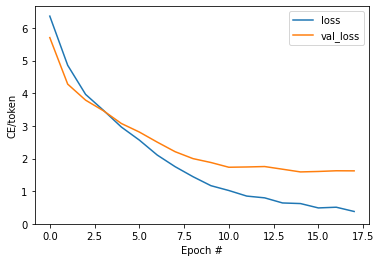

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

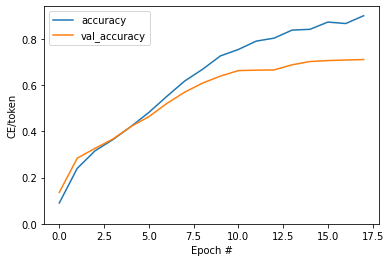

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts,
             *,
              max_length=256,
              temperature=0.0):
  # Process the input texts
  context = self.encoder2.convert_input(texts)

  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Test area

In [ ]:
text = "'bă đơng inh ."
result = model.translate([text]) 
result[0].numpy().decode()

"'bă đei "

In [ ]:
#Run test set
import pandas as pd
df = pd.read_csv('binhdinh.csv')
print("Program starts, please wait for some minutes...")
for idx, sample, truth in zip(df.index, df['Prediction'], df['Truth']):
    # print(str(idx) + " " + sample + " " + truth)
    
  
    result = model.translate([str(sample)])
    pred = result[0].numpy().decode()
    
    
    df.at[idx, 'Correction'] = pred
df.to_csv("correct_binhdinh.csv", index=False)

Program starts, please wait for some minutes...


In [ ]:
with open("ba2ba/valid_predictedba.txt", 'r') as f:
  dt = (f.read()).split("\n")
nw = []
for i in dt:
  result = model.translate([str(i)]) # Are you still home
  pred = result[0].numpy().decode()
  nw.append(pred)
nw = "\n".join(nw)
with open("valid_correctedba.txt", 'w') as f:
  f.write(nw)

In [ ]:
len(nw)

241197

Use that to generate the attention plot:

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

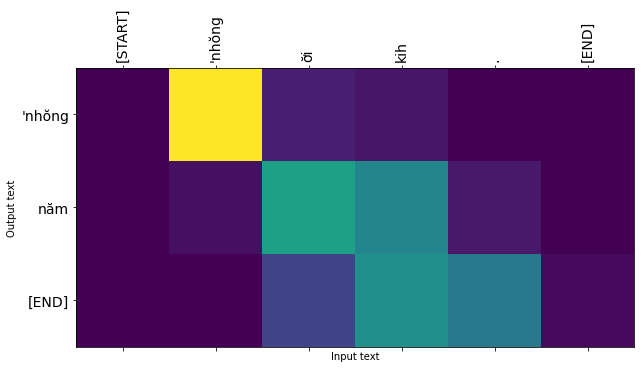

In [ ]:
model.plot_attention("'nhŏng ơ̆i kih .") # Are you still home

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. May be try to use transformer instead.

The raw data is sorted by length, so try translating the longest sequence:

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

In [ ]:
model.plot_attention(long_text)

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the `tf.function` once to compile it:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

NameError: ignored

In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()